In [22]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

In [24]:
# Loop through industries and stocks
for industry, stocks in industries.items():
    for stock in stocks:
        print(f"\n🔍 Processing: {industry}/{stock}")

        file_path = os.path.join("data", industry, f"{stock}.csv")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        # Load and preprocess the data
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Close']]
        
        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df)
        
        # Split into training and testing sets
        train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)
        
        # Check if the test set has enough data
        if len(test_data) < 60:  # 60 is the sequence_length
            print(f"Not enough data in test set for {stock}. Skipping...")
            continue
        
        x_train, y_train = create_sequences(train_data)
        x_test, y_test = create_sequences(test_data)
        
        # Check if sequences were created successfully
        if len(x_train) == 0 or len(x_test) == 0:
            print(f"Not enough data for training or testing: {file_path}")
            continue
        
        # Build and compile the model
        model = build_model((x_train.shape[1], 1))
        model.summary()

        # Callbacks for early stopping and saving the best model
        model_dir = os.path.join("models", industry)
        os.makedirs(model_dir, exist_ok=True)
        model_file = os.path.join(model_dir, f"{stock}_model.keras")  
        scaler_file = os.path.join(model_dir, f"{stock}_scaler.pkl")

        # ✅ Check if the model and scaler already exist
        # if os.path.exists(model_file) and os.path.exists(scaler_file):
        #     print(f"⏩ Model and scaler already exist for {stock}. Skipping...")
        #     continue

        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss', save_best_only=True)

        # Train the model
        history = model.fit(
            x_train, y_train,
            batch_size=32,
            epochs=50,
            validation_split=0.2,
            callbacks=[early_stop, model_checkpoint]
        )

        model.save(model_file) 
        print(f"Model saved in .keras format for {stock}")

        # Save the scaler using pickle
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved for {stock}")

print("\nTraining complete for all stocks!")



🔍 Processing: agro/CBG.BK


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.1559 - val_loss: 0.0385
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0143 - val_loss: 0.0198
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1257 - val_loss: 0.0242
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0108 - val_loss: 0.0097
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0061 - val_loss: 0.0081
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.1105 - val_loss: 0.0186
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0054 - val_loss: 0.0068
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.1359 - val_loss: 0.0157
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0159 - val_loss: 0.0038
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.1183 - val_loss: 0.0098
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0253 - val_loss: 0.0141
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0185 - val_loss: 0.0078
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0143 - val_loss: 0.0081
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0115 - val_loss: 0.0084
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0121 - val_loss: 0.0074
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0097 - val_loss: 0.0073
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0762 - val_loss: 0.0064
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0080 - val_loss: 0.0155
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1132 - val_loss: 0.0125
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0138 - val_loss: 2.5085e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0080 - val_loss: 6.1216e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0052 - val_loss: 2.5596e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0049 - val_loss: 2.2091e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0038 - val_loss: 2.1447e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0046 - val_loss: 2.2885e-04
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_loss: 2.0359e-04
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0049 - val_loss: 2.2185e-04
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0048 - val_loss: 2.2233e-04
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0042 - val_loss: 1.9837e-04
Epoch 12/50
21/21 ━━━━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.1399 - val_loss: 0.0100
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0134 - val_loss: 0.0013
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0062 - val_loss: 0.0011
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0341 - val_loss: 0.0028
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0537 - val_loss: 0.0412
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0043 - val_loss: 0.0080
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.0075
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0040 - val_loss: 0.0098
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0035 - val_loss: 0.0062
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0030 - val_loss: 0.0072
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0905 - val_loss: 0.0074
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0365 - val_loss: 0.0091
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0044 - val_loss: 0.0077
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1367 - val_loss: 0.0250
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0132 - val_loss: 0.0052
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0081 - val_loss: 0.0025
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0075 - val_loss: 0.0036
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.1953 - val_loss: 0.0306
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0169 - val_loss: 0.0233
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0102 - val_loss: 0.0063
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0070 - val_loss: 0.0026
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.2256 - val_loss: 0.0195
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0138 - val_loss: 0.0276
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0086 - val_loss: 0.0187
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.3450 - val_loss: 0.0740
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0664 - val_loss: 0.0031
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0427 - val_loss: 0.0134
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0179 - val_loss: 0.0363
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0235 - val_loss: 0.0154
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0160 - val_loss: 0.0203
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0124 - val_loss: 0.0059
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0107 - val_loss: 0.0044


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0616 - val_loss: 0.0066
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1624 - val_loss: 0.0020
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0175 - val_loss: 0.0018
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0096 - val_loss: 0.0034
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0073 - val_loss: 0.0020
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0259 - val_loss: 0.0152
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0043 - val_loss: 0.0192
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0796 - val_loss: 0.0198
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0166 - val_loss: 0.1412
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0124 - val_loss: 0.0630
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0088 - val_loss: 0.0672
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0097 - val_loss: 0.1087
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0077 - val_loss: 0.0793
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0067 - val_loss: 0.0717
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0074 - val_loss: 0.0903
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0087 - val_loss: 0.0759
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0066 - val_loss: 0.0811
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0083 - val_loss: 0.0807
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0066 - val_loss: 0.0719


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_70 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1455 - val_loss: 0.0249
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0157 - val_loss: 0.0083
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0097 - val_loss: 0.0027
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0578 - val_loss: 0.0027
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0769 - val_loss: 0.0029
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1415 - val_loss: 0.0077
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0148 - val_loss: 0.0029
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0105 - val_loss: 0.0045
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0070 - val_loss: 0.0042
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0895 - val_loss: 0.0032
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0130 - val_loss: 0.0053
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0116 - val_loss: 0.0027
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0098 - val_loss: 0.0024
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0093 - val_loss: 0.0024
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0085 - val_loss: 0.0030
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0089 - val_loss: 0.0023
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0074 - val_loss: 0.0021
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0537 - val_loss: 0.0178
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0083 - val_loss: 0.0051
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_87 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0887 - val_loss: 0.0122
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0156 - val_loss: 0.0105
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0125 - val_loss: 0.0090
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0114 - val_loss: 0.0074
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0112 - val_loss: 0.0089
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0098 - val_loss: 0.0078
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0085 - val_loss: 0.0066
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.2266 - val_loss: 0.0092
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0185 - val_loss: 0.0053
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0114 - val_loss: 0.0044
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0117 - val_loss: 0.0044
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0114 - val_loss: 0.0037
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0098 - val_loss: 0.0048
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0102 - val_loss: 0.0036
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0094 - val_loss: 0.0033
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0074 - val_loss: 0.0032
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_93 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0323 - val_loss: 0.0083
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_96 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_97 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0985 - val_loss: 0.0028
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0082 - val_loss: 0.0019
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_99 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_100 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_101 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.2153 - val_loss: 0.0044
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0206 - val_loss: 0.0037
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0131 - val_loss: 0.0029
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0118 - val_loss: 0.0026
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0104 - val_loss: 0.0024
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0086 - val_loss: 0.0023
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0089 - val_loss: 0.0042
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0076 - val_loss: 0.0054
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_102 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_103 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_104 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0117 - val_loss: 0.0044
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0014 - val_loss: 5.4889e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 5.1909e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0011 - val_loss: 5.0967e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0011 - val_loss: 8.2506e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 5.4787e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.8045e-04 - val_loss: 5.3636e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - val_loss: 7.7045e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_105 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0303 - val_loss: 3.8608e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0032 - val_loss: 5.9345e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 3.7840e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0015 - val_loss: 4.3664e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 3.4444e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 8.8654e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0013 - val_loss: 8.8762e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0013 - val_loss: 7.8683e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0010 - val_loss: 8.2999e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012 - val_loss: 3.0554e-04
Epoch 12/50
24/24 ━━━━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_108 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0274 - val_loss: 0.0040
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_111 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_113 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0042 - val_loss: 4.8079e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.5534e-04 - val_loss: 4.1474e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.6376e-04 - val_loss: 3.6290e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.0492e-04 - val_loss: 3.2220e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 2.2453e-04 - val_loss: 3.0876e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.6277e-04 - val_loss: 2.9158e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.0689e-04 - val_loss: 2.7264e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.9958e-04 - val_loss: 2.6207e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.4563e-04 - val_loss: 2.4737e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.0763e-04 - val_loss: 2.4098e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.9895e-04 - 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_114 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_115 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0198 - val_loss: 0.0019
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 9.3855e-04 - val_loss: 0.0013
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.9589e-04 - val_loss: 0.0013
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - l

In [ ]:
# --------------------------------------------------------------
# Train as Individual

In [10]:
# Load the latest preprocessed data from CSV file
# file_path = os.path.join("data", "Fincial", "SCB.BK.csv")
import yfinance as yf
import datetime
import os

# ticker = 'SCB.BK'

# Download historical data from Yahoo Finance (period="5y")
# df = yf.download(ticker, start='2020-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'), auto_adjust=True) #show adjusted close price

file_path = os.path.join("data", "Fincial", "KBANK.BK.csv")

# Load and preprocess the data
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]
df

,Close
Date,
2020-01-02,128.455139
2020-01-03,127.618286
2020-01-06,120.086739
2020-01-07,119.668304
2020-01-08,117.157791
...,...
2025-02-10,159.000000
2025-02-11,158.000000
2025-02-13,155.000000


In [11]:
# Scale to range 0, 1
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
scaled_data = scaler.fit_transform(df)
processed_data = pd.DataFrame(scaled_data, columns=['Close'])
processed_data

,Close
0,0.654743
1,0.646498
2,0.572299
3,0.568176
4,0.543443
...,...
1238,0.955667
1239,0.945815
1240,0.916259
1241,0.901481


In [12]:
# Split into the training and testing sets
train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Past 60 days
        y.append(data[i, 0])                    # Target: the next day’s close price

    # Convert to NumPy arrays
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

x_train, y_train = create_sequences(train_data)
x_test, y_test = create_sequences(test_data)

# Print dataset shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}" if len(x_test) > 0 else "⚠️ No test set available.")
print(f"y_test shape: {y_test.shape}" if len(y_test) > 0 else "")

x_train shape: (934, 60, 1)
y_train shape: (934,)
x_test shape: (189, 60, 1)
y_test shape: (189,)


In [13]:
# Step 4: Build LSTM Model

# Create the LSTM model
model = Sequential()

# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Third LSTM layer with 50 units and return sequences=False
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Dense layer with 25 units
model.add(Dense(units=25))

# Output layer with 1 unit (the predicted price)
model.add(Dense(units=1))

# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Step 5: Train the Model

# Add EarlyStopping to monitor the loss and stop training if it doesn’t improve
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Save the best model during training using ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True)

# Train the model with batch size of 32 and for 50 epochs (can be adjusted)
history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stop, model_checkpoint], validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0992 - val_loss: 0.0078
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0119 - val_loss: 0.0011
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0086 - val_loss: 0.0011
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0063 - val_loss: 0.0011
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0

In [15]:
# Step 6: Generate predictions for 30-day forecast

# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

# Reshape last_60_days to fit the model input shape
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list
    
    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

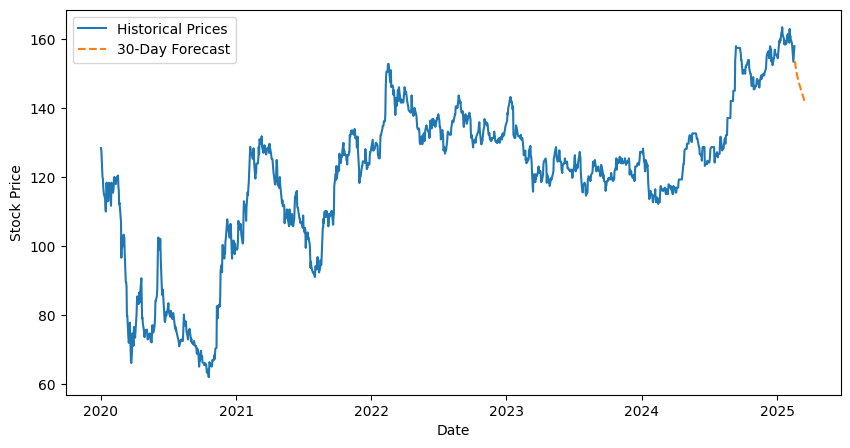

In [16]:
# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Historical Prices')
plt.plot(predictions_df, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
# Step 7: Evaluationg model

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, test_predictions)
mae = mean_absolute_error(y_test_rescaled, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_rescaled - test_predictions) / y_test_rescaled)) * 100

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Mean Absolute Error: 2.554087199862041
Root Mean Squared Error: 3.205954378263796
Mean Absolute Percentage Error (MAPE): 1.7503815334216781%


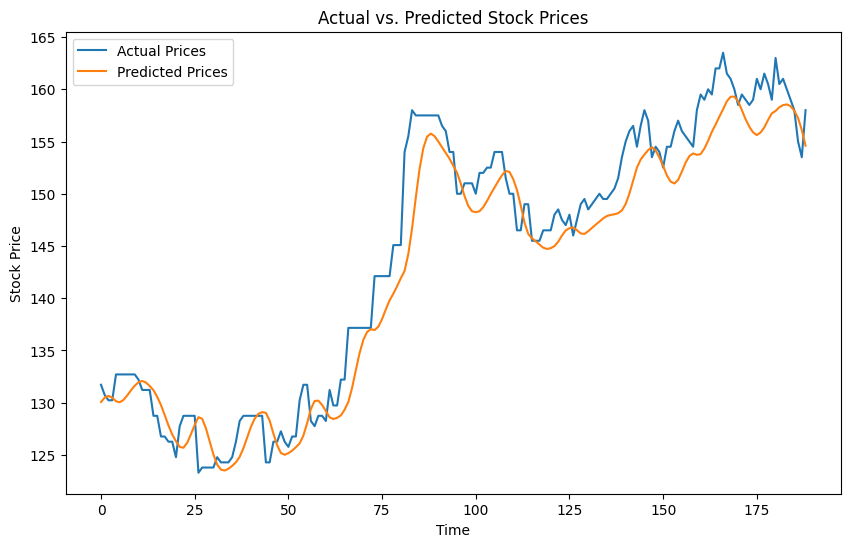

In [21]:
# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()